In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn.init as init
import time
from torch.optim.lr_scheduler import StepLR

In [4]:
t_start = 0
t_end = 1
n_timepoints = 5
t_values = torch.linspace(t_start, t_end, n_timepoints)
t_values.shape

torch.Size([5])

In [ ]:
gl_points = torch.tensor([
    -0.9061798459,
    -0.5384693101,
     0.0,
     0.5384693101,
     0.9061798459
])
mapped_points = 0.5 * gl_points + 0.5


torch.Size([5])

In [ ]:
# PINN architecture for 2D problem
import torch
import torch.nn as nn

class PINN2D(nn.Module):
    def __init__(self, num_hidden_layers=4, num_neurons_per_layer=128):
        super().__init__()
        
        # Input layer: new input is 5D after transformation
        self.input_layer = nn.Linear(5, num_neurons_per_layer)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer) 
            for _ in range(num_hidden_layers)
        ])
        
        # Output layer: output 4 dimensions
        self.output_layer = nn.Linear(num_neurons_per_layer, 4)

        # Activation function
        self.activation = nn.Tanh()
        
        # Initialize weights using Xavier initialization
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

    def forward(self, x, y, t):
        # Step 1: Transform (x, y) using sin/cos
        x_cos = torch.cos(x)
        x_sin = torch.sin(x)
        y_cos = torch.cos(y)
        y_sin = torch.sin(y)

        # Step 2: Concatenate transformed inputs with t
        inputs = torch.cat([x_cos, x_sin, y_cos, y_sin, t], dim=1)

        # Step 3: Pass through network
        outputs = self.activation(self.input_layer(inputs))
        for layer in self.hidden_layers:
            outputs = self.activation(layer(outputs)) + outputs  

        # Step 4: Pass through output layer (4D output)
        outputs = self.output_layer(outputs)  

        # Step 5: Convert (cos(x), sin(x), cos(y), sin(y)) back to (x, y)
        x_pred = torch.atan2(outputs[:, 1], outputs[:, 0])  # atan2(sin, cos)
        y_pred = torch.atan2(outputs[:, 3], outputs[:, 2])  # atan2(sin, cos)

        # Step 6: Stack to return 2D output
        return torch.stack([x_pred, y_pred], dim=1)

In [25]:
from torch.distributions import VonMises

In [26]:
# PDE residual formula for 2D diffusion equation
def pde_formula(x, y, t, a):

    # Get the partial derivative of log probability with t
    prob_x = VonMises(torch.tensor([0.0],device = 'cuda'), t)
    prob_y = VonMises(torch.tensor([0.0],device = 'cuda'), t)
    log_prob_x = prob_x.log_prob(x)
    log_prob_y = prob_y.log_prob(y)
    joint_log_prob = log_prob_x + log_prob_y
    grad_log_prob = grad(joint_log_prob, t, grad_outputs=torch.ones_like(joint_log_prob), create_graph=True)[0]
    
    # Get the vector field components (not just derivatives)
    a_x = a[:,0:1]  # This should be the x-component
    a_y = a[:,1:2]  # This should be the y-component
    
    # Calculate divergence: ∇·a = ∂a_x/∂x + ∂a_y/∂y
    # First compute derivative of a_x with respect to x
    da_x_dx = grad(a_x, x, grad_outputs=torch.ones_like(a_x), create_graph=True)[0]
    
    # Then compute derivative of a_y with respect to y
    da_y_dy = grad(a_y, y, grad_outputs=torch.ones_like(a_y), create_graph=True)[0]
    
    # Divergence is the sum of these derivatives
    divergence = da_x_dx + da_y_dy
    
    # Compute terms in the PDE
    
    term2 = grad_log_prob
    term3 = (a_x*torch.sin(x) + a_y*torch.sin(y))
    term3 = t*term3
    term4 = divergence
    
    # Return the PDE residual
    return (term2 - term3 + term4)**2

In [27]:
# Initial condition at t=0
def initial_condition_func(x, y):
    # 2D Gaussian pulse
    # return torch.exp(-0.5 * (x**2 + y**2))
    return 1

# Boundary conditions for x boundaries
def boundary_func_x_minus(y, t):
    # Zero value at x=-10 boundary
    return torch.zeros_like(y)

def boundary_func_x_plus(y, t):
    # Zero value at x=10 boundary
    return torch.zeros_like(y)

# Boundary conditions for y boundaries
def boundary_func_y_minus(x, t):
    # Zero value at y=-10 boundary
    return torch.zeros_like(x)

def boundary_func_y_plus(x, t):
    # Zero value at y=10 boundary
    return torch.zeros_like(x)

In [28]:
# Loss function for 2D PINN with time range [0.1, 1] and vector output correction
def compute_loss(model, device='cuda'):
    # Sample collocation points for PDE residual
    n_pde_points = 10000  # Number of points inside domain

    samples = torch.rand(n_pde_points, 3, device=device)

    # 计算线性变换后的结果
    result = samples * torch.tensor([[2*np.pi, 2*np.pi, 0.9]], device=device) + torch.tensor([[-np.pi, -np.pi, 0.1]], device=device)

    # 按列拆分结果
    x_pde, y_pde, t_pde = result.unbind(dim=1)

    # 保持二维结构（可选，根据需求调整）
    x_pde = x_pde.reshape(-1, 1)
    y_pde = y_pde.reshape(-1, 1)
    t_pde = t_pde.reshape(-1, 1)
    
    # For PDE residual, we need gradients
    x_pde.requires_grad_(True)
    y_pde.requires_grad_(True)
    t_pde.requires_grad_(True)
    
    # PDE residual loss
    u_pde = model(x_pde, y_pde, t_pde)
    residual = pde_formula(x_pde, y_pde, t_pde, u_pde)
    pde_loss = residual**2
    pde_loss = torch.mean(pde_loss)
    
    # Initial condition points at t=0.1 (smallest valid t)
    n_ic_points = 1000
    x_ic = torch.rand(n_ic_points, 1, device=device) * 2*np.pi - np.pi    # Range [-10, 10]
    y_ic = torch.rand(n_ic_points, 1, device=device) * 2*np.pi - np.pi    # Range [-10, 10]
    t_ic = torch.ones(n_ic_points, 1, device=device) * 0.1        # t = 0.1 (minimum time)
    u_ic_pred = model(x_ic, y_ic, t_ic)
    u_ic_true = initial_condition_func(x_ic, y_ic)
    ic_loss = torch.sum((u_ic_pred - u_ic_true)**2,dim = 1)
    ic_loss = torch.mean(ic_loss)
    
    # Boundary conditions
    n_bc_points = 1000
    
    # Left boundary (x = -10)
    y_bc_left = torch.rand(n_bc_points, 1, device=device) * 2*np.pi - np.pi  # Range [-10, 10]
    t_bc_left = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    x_bc_left = -np.pi * torch.ones_like(y_bc_left, device=device)
    u_bc_left_pred = model(x_bc_left, y_bc_left, t_bc_left)
    u_bc_left_true = boundary_func_x_minus(y_bc_left, t_bc_left)
    bc_loss_left = torch.sum((u_bc_left_pred - u_bc_left_true)**2,dim = 1)
    bc_loss_left = torch.mean(bc_loss_left)
    
    # Right boundary (x = 10)
    y_bc_right = torch.rand(n_bc_points, 1, device=device) * 2*np.pi - np.pi # Range [-10, 10]
    t_bc_right = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    x_bc_right = np.pi * torch.ones_like(y_bc_right, device=device)
    u_bc_right_pred = model(x_bc_right, y_bc_right, t_bc_right)
    u_bc_right_true = boundary_func_x_plus(y_bc_right, t_bc_right)
    bc_loss_right = torch.sum((u_bc_right_pred - u_bc_right_true)**2,dim = 1)
    bc_loss_right = torch.mean(bc_loss_right)
    
    # Bottom boundary (y = -10)
    x_bc_bottom = torch.rand(n_bc_points, 1, device=device) * 2*np.pi - np.pi  # Range [-10, 10]
    t_bc_bottom = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    y_bc_bottom = -np.pi * torch.ones_like(x_bc_bottom, device=device)
    u_bc_bottom_pred = model(x_bc_bottom, y_bc_bottom, t_bc_bottom)
    u_bc_bottom_true = boundary_func_y_minus(x_bc_bottom, t_bc_bottom)
    bc_loss_bottom = torch.sum((u_bc_bottom_pred - u_bc_bottom_true)**2,dim = 1)
    bc_loss_bottom = torch.mean(bc_loss_bottom)
    
    # Top boundary (y = 10)
    x_bc_top = torch.rand(n_bc_points, 1, device=device) * 2*np.pi - np.pi  # Range [-10, 10]
    t_bc_top = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    y_bc_top = np.pi * torch.ones_like(x_bc_top, device=device)
    u_bc_top_pred = model(x_bc_top, y_bc_top, t_bc_top)
    u_bc_top_true = boundary_func_y_plus(x_bc_top, t_bc_top)
    bc_loss_top = torch.sum((u_bc_top_pred - u_bc_top_true)**2,dim = 1)
    bc_loss_top = torch.mean(bc_loss_top)
    
    # Total boundary loss
    bc_loss = bc_loss_left + bc_loss_right + bc_loss_bottom + bc_loss_top
    
    # Total loss
    total_loss = pde_loss + ic_loss + bc_loss
    
    return total_loss, pde_loss, ic_loss, bc_loss

In [29]:
# Training function
def train(model, optimizer,scheduler, n_epochs=10000, print_every=1000):
    start_time = time.time()
    loss_history = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        total_loss,pde_loss,ic_loss,bc_loss = compute_loss(model)
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_history.append(total_loss.item())
        
        if epoch % print_every == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch}/{n_epochs} - Time: {elapsed:.2f}s - "
                  f"Loss: {total_loss.item():.6f}, PDE: {pde_loss.item():.6f}, "
                  f"IC: {ic_loss.item():.6f}, BC: {bc_loss.item():.6f}")
    
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    return model, loss_history

In [ ]:
device = torch.device("cuda")
model = PINN2D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=200, gamma=0.99)
trained_model, loss_history = train(model, optimizer,scheduler,n_epochs=100000, print_every=100)
# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True)
plt.show()

Epoch 0/100000 - Time: 0.04s - Loss: 6265.637207, PDE: 6230.974609, IC: 6.115753, BC: 28.546677
Epoch 100/100000 - Time: 2.65s - Loss: 85.835129, PDE: 27.886106, IC: 5.498279, BC: 52.450745
Epoch 200/100000 - Time: 5.22s - Loss: 84.763649, PDE: 27.321762, IC: 5.117154, BC: 52.324734
Epoch 300/100000 - Time: 7.86s - Loss: 84.761681, PDE: 27.256159, IC: 5.365798, BC: 52.139725
Epoch 400/100000 - Time: 10.13s - Loss: 84.665222, PDE: 27.021124, IC: 5.396206, BC: 52.247887
Epoch 500/100000 - Time: 12.69s - Loss: 85.608795, PDE: 28.116249, IC: 5.357135, BC: 52.135406
Epoch 600/100000 - Time: 15.29s - Loss: 82.558823, PDE: 25.363585, IC: 5.357312, BC: 51.837925
Epoch 700/100000 - Time: 17.81s - Loss: 83.805458, PDE: 26.350412, IC: 5.472680, BC: 51.982365
Epoch 800/100000 - Time: 20.11s - Loss: 84.084030, PDE: 26.576134, IC: 5.293397, BC: 52.214500
Epoch 900/100000 - Time: 22.12s - Loss: 83.046310, PDE: 26.070164, IC: 5.010309, BC: 51.965836
Epoch 1000/100000 - Time: 24.12s - Loss: 84.631516, 

In [18]:
total_params = 0
for p in model.parameters():
    if p.requires_grad:
        total_params += p.numel()

# 打印可学习参数数量
print(f"模型中的可学习参数数量: {total_params}")

模型中的可学习参数数量: 67332


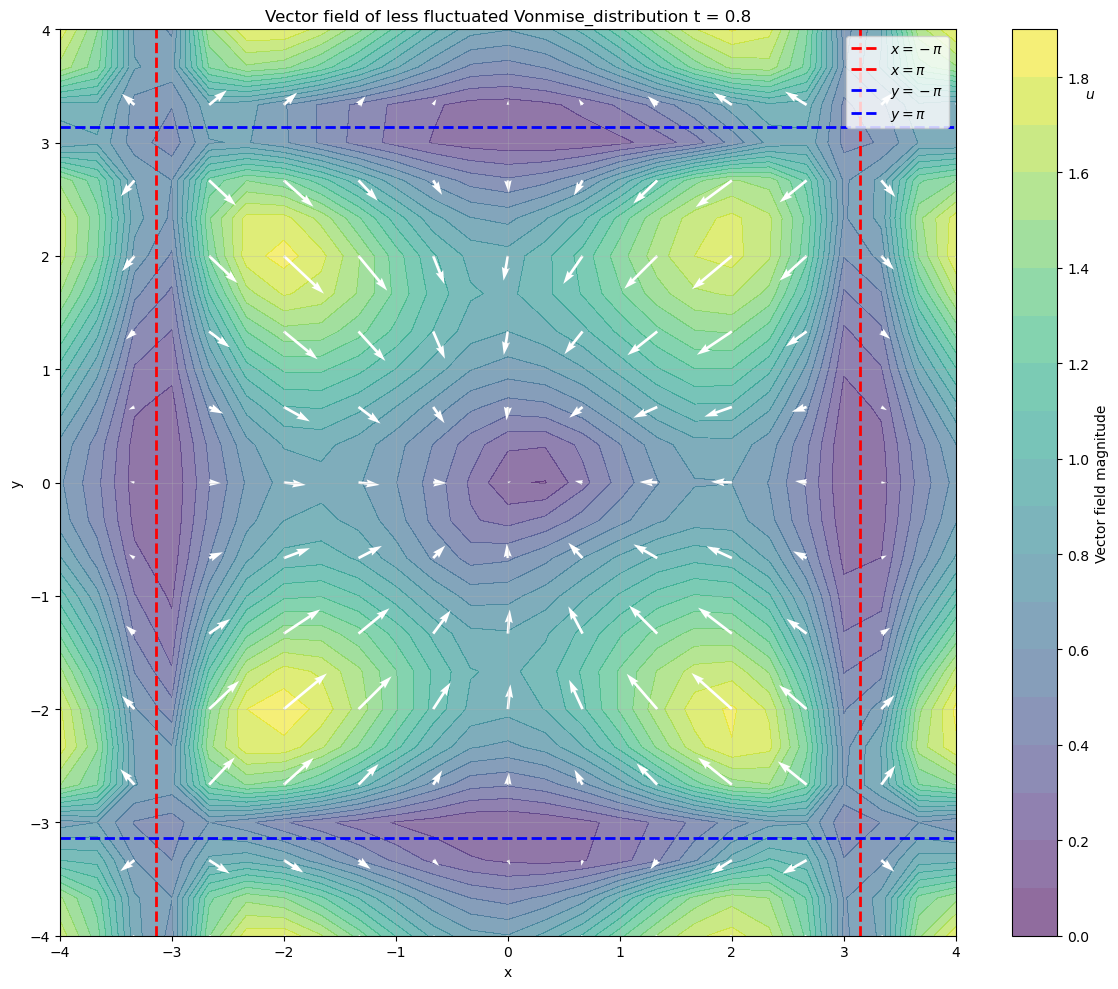

In [22]:
# Function to plot vector field of the solution
"""
Plots the vector field (gradient) of the solution at time t_val.

Args:
    model: Trained PINN model
    t_val: Time value to plot
    grid_size: Number of points in each dimension for visualization
"""
t_val = 0.8
grid_size = 25
# Create a grid for visualization
x = np.linspace(-4, 4, grid_size)
y = np.linspace(-4, 4, grid_size)
X, Y = np.meshgrid(x, y)

# Convert to PyTorch tensors
x_tensor = torch.tensor(X.flatten(), dtype=torch.float32,device = 'cuda').unsqueeze(1).requires_grad_(True)
y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32,device = 'cuda').unsqueeze(1).requires_grad_(True)
t_tensor = torch.ones_like(x_tensor,device = 'cuda') * t_val

# Predict using the model to get vector field
model.eval()
with torch.no_grad():  # No need for gradients here
    vector_field = model(x_tensor, y_tensor, t_tensor)
    
vector_field = vector_field.to('cpu').detach().numpy()
# Extract vector components
u_x = vector_field[:, 0].reshape(X.shape)  # x-component
u_y = vector_field[:, 1].reshape(X.shape)  # y-component

# Calculate magnitude for the contour plot
magnitude = np.sqrt(u_x**2 + u_y**2)

# Plotting
fig = plt.figure(figsize=(12, 10))

# Plot contours of the vector magnitude
contour = plt.contourf(X, Y, magnitude, 20, cmap='viridis', alpha=0.6)
plt.colorbar(contour, label='Vector field magnitude')

# Downsample for clearer vector field if needed
skip = 2  # Adjust based on grid_size

# Plot vector field
quiver = plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                   u_x[::skip, ::skip], u_y[::skip, ::skip], 
                   color='white', scale=30, width=0.003)

plt.title(f'Vector field of less fluctuated Vonmise_distribution t = {t_val}')
plt.xlabel('x')
plt.ylabel('y')

pi = np.pi
plt.axvline(-pi, color='red', linestyle='--', linewidth=2, label='$x = -\pi$')
plt.axvline(pi, color='red', linestyle='--', linewidth=2, label='$x = \pi$')
plt.axhline(-pi, color='blue', linestyle='--', linewidth=2, label='$y = -\pi$')
plt.axhline(pi, color='blue', linestyle='--', linewidth=2, label='$y = \pi$')

# Add legend for boundaries
plt.legend(loc='upper right')


# Add vector field scale reference
plt.quiverkey(quiver, 0.9, 0.9, 1, r'$u$', labelpos='E',
               coordinates='figure')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
fig.savefig('pinn_Vonmise_Real_0.8.png')
# Visualize vector fields at different time points



In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 定义要遍历的 t 值列表
t_values = [0.1, 0.3, 0.5, 1.0]
grid_size = 25

# 创建固定网格（只需计算一次）
x = np.linspace(-4, 4, grid_size)
y = np.linspace(-4, 4, grid_size)
X, Y = np.meshgrid(x, y)

# 转换为 PyTorch 张量（GPU 加速）
x_tensor = torch.tensor(X.flatten(), dtype=torch.float32, device='cuda').unsqueeze(1)
y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32, device='cuda').unsqueeze(1)

# 模型设为评估模式
model.eval()

# 预先生成所有数据并收集 magnitude 的范围
all_data = []
all_magnitudes = []
for t_val in t_values:
    t_tensor = torch.ones_like(x_tensor, device='cuda') * t_val
    with torch.no_grad():
        vector_field = model(x_tensor, y_tensor, t_tensor)
    vector_field = vector_field.cpu().numpy()
    u_x = vector_field[:, 0].reshape(X.shape)
    u_y = vector_field[:, 1].reshape(X.shape)
    magnitude = np.sqrt(u_x**2 + u_y**2)
    all_data.append((u_x, u_y, magnitude))
    all_magnitudes.append(magnitude)

# 确定全局颜色范围
global_vmin = min([mag.min() for mag in all_magnitudes])
global_vmax = max([mag.max() for mag in all_magnitudes])

# 创建包含4个子图的大图，调整布局为颜色条预留空间
fig = plt.figure(figsize=(20, 16))
# 调整子图布局：左侧和底部边距为0.1，右侧边距为0.9（为颜色条留空间）
plt.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

# 公共参数设置
pi = np.pi
skip = 2  # 下采样步长

# 遍历每个子图进行绘制
for i, (t_val, (u_x, u_y, magnitude)) in enumerate(zip(t_values, all_data)):
    ax = fig.add_subplot(2, 2, i+1)  # 动态添加子图
    
    # 绘制等高线图（统一颜色范围）
    contour = ax.contourf(X, Y, magnitude, 20, cmap='viridis', alpha=0.6, 
                         vmin=global_vmin, vmax=global_vmax)
    
    # 绘制向量箭头
    quiver = ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                      u_x[::skip, ::skip], u_y[::skip, ::skip], 
                      color='white', scale=30, width=0.003)
    
    # 添加标题和坐标轴标签
    ax.set_title(f't = {t_val}', fontsize=12)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # 绘制边界线
    ax.axvline(-pi, color='red', linestyle='--', linewidth=1)
    ax.axvline(pi, color='red', linestyle='--', linewidth=1)
    ax.axhline(-pi, color='blue', linestyle='--', linewidth=1)
    ax.axhline(pi, color='blue', linestyle='--', linewidth=1)
    
    # 添加网格
    ax.grid(True, alpha=0.3)

# 添加全局颜色条（放置在右侧）
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(contour, cax=cbar_ax, label='Vector Field Magnitude')
cbar.ax.tick_params(labelsize=10)

# 添加总标题
fig.suptitle('Von Mises Distribution Vector Fields at Different Times', 
             fontsize=16, y=0.95)

# 保存图片
plt.savefig('pinn_Vonmise_subplots.png', bbox_inches='tight')
plt.close(fig)

print("四张子图生成完成！")

四张子图生成完成！


## Save the trained model

In [13]:
torch.save(model, 'PINN_Vonmise_Real.pth')

## Check the periodic boundary condition of trained model

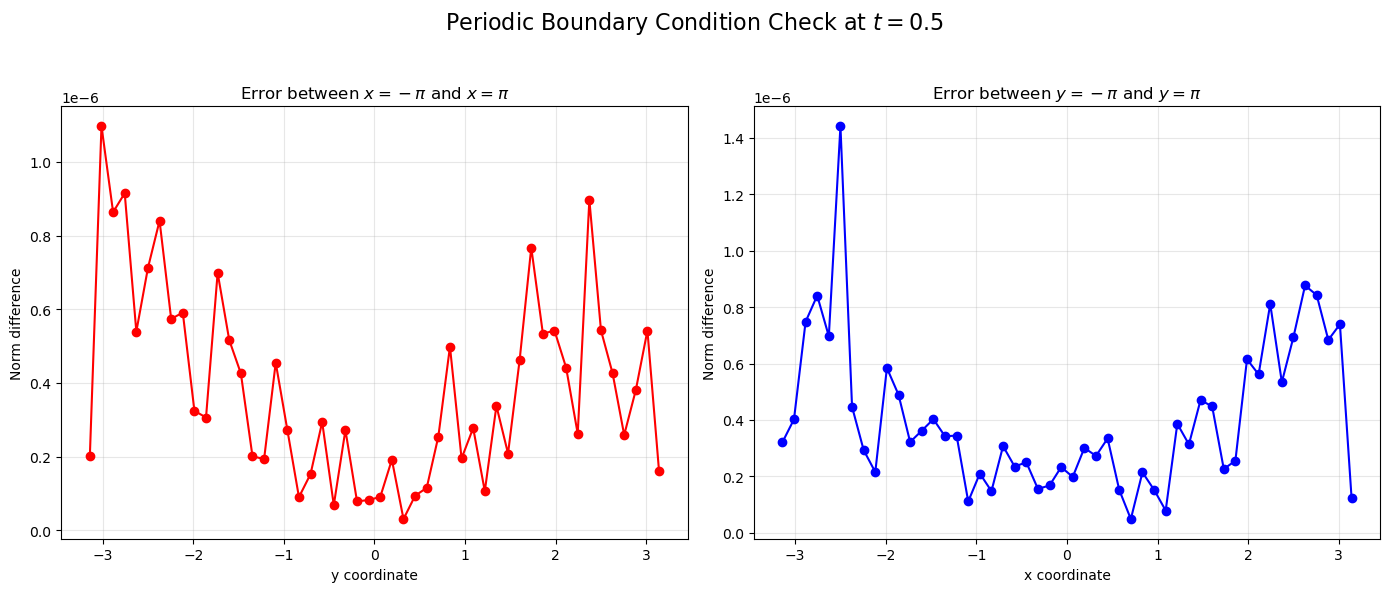

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set device and t value
device = torch.device('cuda')
t_val = 0.5
pi = np.pi
n_samples = 50  # number of points along the boundary

# ============================
# Check periodicity in x-direction
# ============================
# For each y in [-pi, pi], compare vector_field at x = -pi and x = pi.
y_vals = np.linspace(-pi, pi, n_samples)

# Create tensors for boundary evaluation at x = -pi and x = pi.
x_left = torch.full((n_samples, 1), -pi, dtype=torch.float32, device=device)
x_right = torch.full((n_samples, 1), pi, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y_vals, dtype=torch.float32, device=device).unsqueeze(1)
t_tensor = torch.full((n_samples, 1), t_val, dtype=torch.float32, device=device)

# Evaluate the model on the left and right boundaries.
trained_model.eval()
with torch.no_grad():
    vector_left = trained_model(x_left, y_tensor, t_tensor)
    vector_right = trained_model(x_right, y_tensor, t_tensor)

# Move to CPU and convert to NumPy arrays.
vector_left = vector_left.cpu().numpy()
vector_right = vector_right.cpu().numpy()

# Compute the norm of the difference for each y coordinate.
error_x = np.linalg.norm(vector_left - vector_right, axis=1)

# ============================
# Check periodicity in y-direction
# ============================
# For each x in [-pi, pi], compare vector_field at y = -pi and y = pi.
x_vals = np.linspace(-pi, pi, n_samples)
x_tensor = torch.tensor(x_vals, dtype=torch.float32, device=device).unsqueeze(1)
y_bottom = torch.full((n_samples, 1), -pi, dtype=torch.float32, device=device)
y_top = torch.full((n_samples, 1), pi, dtype=torch.float32, device=device)
t_tensor = torch.full((n_samples, 1), t_val, dtype=torch.float32, device=device)

with torch.no_grad():
    vector_bottom = trained_model(x_tensor, y_bottom, t_tensor)
    vector_top = trained_model(x_tensor, y_top, t_tensor)

vector_bottom = vector_bottom.cpu().numpy()
vector_top = vector_top.cpu().numpy()

# Compute the norm of the difference for each x coordinate.
error_y = np.linalg.norm(vector_bottom - vector_top, axis=1)

# ============================
# Visualization of the periodicity check results
# ============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the error along the x-boundaries as a function of y.
axes[0].plot(y_vals, error_x, 'o-', color='red')
axes[0].set_title('Error between $x=-\pi$ and $x=\pi$')
axes[0].set_xlabel('y coordinate')
axes[0].set_ylabel('Norm difference')
axes[0].grid(True, alpha=0.3)

# Plot the error along the y-boundaries as a function of x.
axes[1].plot(x_vals, error_y, 'o-', color='blue')
axes[1].set_title('Error between $y=-\pi$ and $y=\pi$')
axes[1].set_xlabel('x coordinate')
axes[1].set_ylabel('Norm difference')
axes[1].grid(True, alpha=0.3)

fig.suptitle(f'Periodic Boundary Condition Check at $t={t_val}$', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## call the saved model

In [28]:
model = torch.load("PINN_Vonmise.pth")
model

PINN2D(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-5): 6 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (activation): Tanh()
)

## Define the integral function

In [14]:
def solve_ivp_torch(fun: nn.Module, t_span, y0, method='RK45', rtol=1e-3, atol=1e-6):
    """
    A batch-friendly ODE solver using SciPy's solve_ivp internally.
    NOTE: Results are not differentiable through PyTorch autograd.
    """
    B, ND = y0.shape
    device = y0.device

    def fun_wrapper(t, y):
        # 1) Convert incoming y (numpy array) to a PyTorch tensor
        y_torch = torch.from_numpy(y).float().to('cuda').reshape(-1, ND)

        # 2) Convert scalar t to a tensor of shape (B, 1)
        t_torch = torch.ones_like(y_torch[:, :1], device='cuda') * t

        # 3) Evaluate the user-specified function (the ODE’s right-hand side)
        vt = fun(y_torch[:,0:1],y_torch[:,1:2], t_torch)

        # 4) Convert the result back to numpy, flatten
        return vt.detach().cpu().numpy().reshape(-1)

    # Flatten initial y0 to shape (B*ND,)
    import numpy as np
    from scipy.integrate import solve_ivp

    y0_np = y0.detach().cpu().numpy().reshape(-1)

    sol = solve_ivp(
        fun_wrapper,
        t_span,
        y0_np,
        method=method,
        rtol=rtol,
        atol=atol
    )

    # Return the final solution at t_span[-1], shape (B, ND)
    final_y = sol.y[:, -1]
    final_y_torch = torch.from_numpy(final_y).float().to(device).reshape(B, ND)
    return final_y_torch

torch.Size([200000, 2])
x range: -3.141545534133911 3.141571283340454
y range: -3.1415536403656006 3.141587495803833


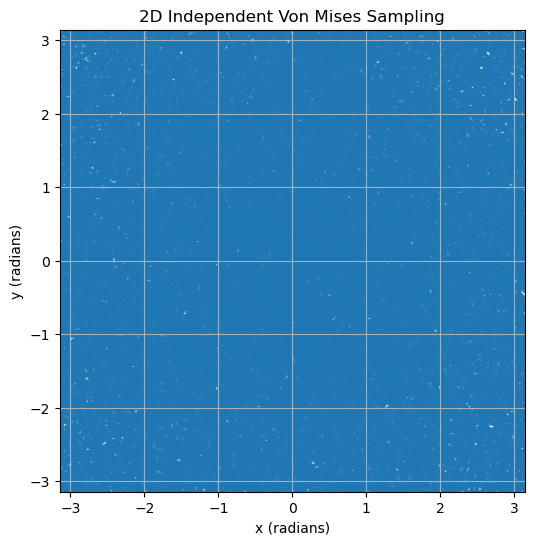

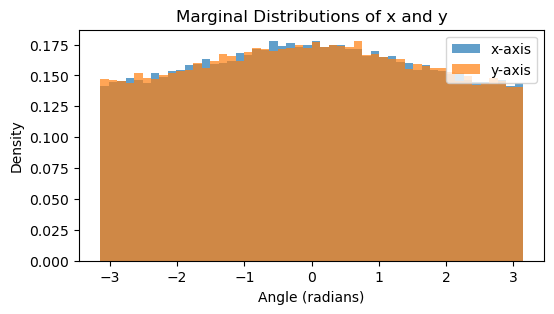

In [15]:
import torch
import math
import matplotlib.pyplot as plt

import torch
import math
import matplotlib.pyplot as plt

# 设定样本数量
num_samples =200000

# 设定 Von Mises 分布参数
mu_x = 0.0      # x 方向均值角度
mu_y = 0.0      # y 方向均值角度
kappa_x = 0.1   # x 方向集中度
kappa_y = 0.1   # y 方向集中度

# 1. 分别从两个独立的 Von Mises 分布中采样 x 和 y
dist_x = torch.distributions.VonMises(mu_x, kappa_x)
dist_y = torch.distributions.VonMises(mu_y, kappa_y)

samples_x = dist_x.sample((num_samples,))
samples_y = dist_y.sample((num_samples,))

# 2. 确保所有样本严格在 [-π, π] 盒子里（一般不需要，因为 PyTorch 采样默认在 [-π, π]）
samples_x = torch.remainder(samples_x + math.pi, 2 * math.pi) - math.pi
samples_y = torch.remainder(samples_y + math.pi, 2 * math.pi) - math.pi

# 3. 组合成 2D 样本
samples_2d = torch.stack((samples_x, samples_y), dim=1)  # shape: [10000, 2]

# 输出形状检查
print(samples_2d.shape)  # 应该是 [10000, 2]
print("x range:", samples_x.min().item(), samples_x.max().item())
print("y range:", samples_y.min().item(), samples_y.max().item())

# 4. 可视化结果
plt.figure(figsize=(6,6))
plt.scatter(samples_x.numpy(), samples_y.numpy(), s=2, alpha=0.5)
plt.xlim(-math.pi, math.pi)
plt.ylim(-math.pi, math.pi)
plt.xlabel("x (radians)")
plt.ylabel("y (radians)")
plt.title("2D Independent Von Mises Sampling")
plt.grid(True)
plt.show()

# 5. 分别绘制 x 和 y 的直方图
plt.figure(figsize=(6,3))
plt.hist(samples_x.numpy(), bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(samples_y.numpy(), bins=50, alpha=0.7, density=True, label="y-axis")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Marginal Distributions of x and y")
plt.legend()
plt.show()

torch.Size([200000, 2])
x range: -3.1412832736968994 3.1414382457733154
y range: -3.1414554119110107 3.1415350437164307


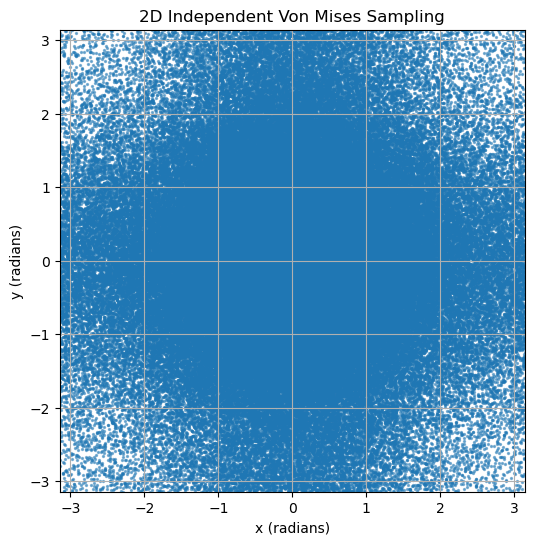

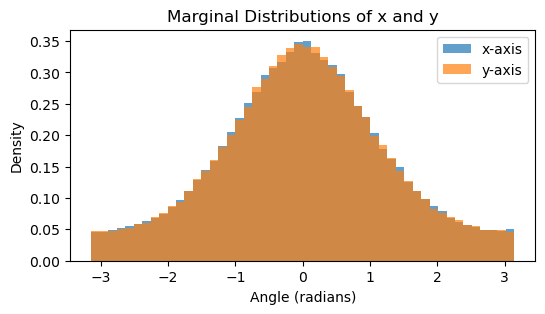

In [17]:
num_samples = 200000

# 设定 Von Mises 分布参数
mu_x = 0.0      # x 方向均值角度
mu_y = 0.0      # y 方向均值角度
kappa_x = 1   # x 方向集中度
kappa_y = 1   # y 方向集中度

# 1. 分别从两个独立的 Von Mises 分布中采样 x 和 y
dist_x = torch.distributions.VonMises(mu_x, kappa_x)
dist_y = torch.distributions.VonMises(mu_y, kappa_y)

samples_x = dist_x.sample((num_samples,))
samples_y = dist_y.sample((num_samples,))

# 2. 确保所有样本严格在 [-π, π] 盒子里（一般不需要，因为 PyTorch 采样默认在 [-π, π]）
samples_x = torch.remainder(samples_x + math.pi, 2 * math.pi) - math.pi
samples_y = torch.remainder(samples_y + math.pi, 2 * math.pi) - math.pi

# 3. 组合成 2D 样本
samples_2d_concentrated = torch.stack((samples_x, samples_y), dim=1)  # shape: [10000, 2]

# 输出形状检查
print(samples_2d_concentrated.shape)  # 应该是 [10000, 2]
print("x range:", samples_x.min().item(), samples_x.max().item())
print("y range:", samples_y.min().item(), samples_y.max().item())

# 4. 可视化结果
plt.figure(figsize=(6,6))
plt.scatter(samples_x.numpy(), samples_y.numpy(), s=2, alpha=0.5)
plt.xlim(-math.pi, math.pi)
plt.ylim(-math.pi, math.pi)
plt.xlabel("x (radians)")
plt.ylabel("y (radians)")
plt.title("2D Independent Von Mises Sampling")
plt.grid(True)
plt.show()

# 5. 分别绘制 x 和 y 的直方图
plt.figure(figsize=(6,3))
plt.hist(samples_x.numpy(), bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(samples_y.numpy(), bins=50, alpha=0.7, density=True, label="y-axis")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Marginal Distributions of x and y")
plt.legend()
plt.show()

In [18]:
# Suppose ND=2, so our state y = (x, v) or something like that
# We'll define a network with input_dim=ND+1=3, hidden_dim=16, output_dim=ND=2

# Integrate from t = 0 to t = 1
t_span = (0.1, 1.0)

# Solve
final_y = solve_ivp_torch(model, t_span, samples_2d)
print(final_y.shape)

torch.Size([200000, 2])


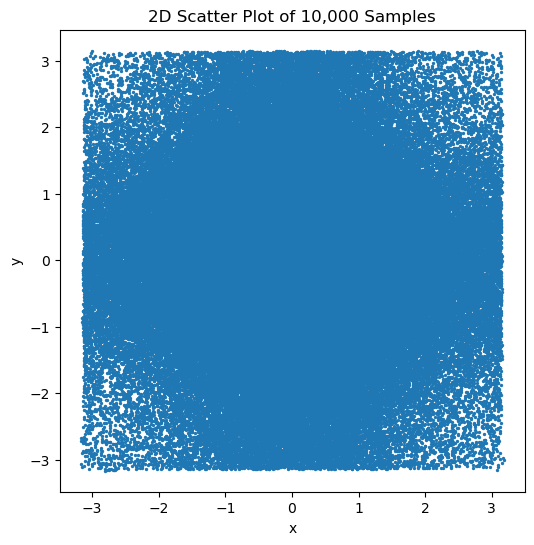

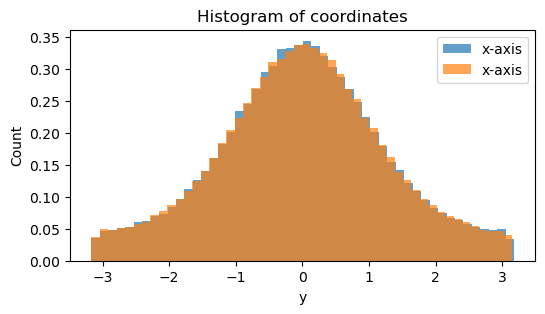

In [19]:
samples_np = final_y.cpu().numpy()

x_vals = samples_np[:, 0]
y_vals = samples_np[:, 1]

# 1) Scatter plot of (x, y)
plt.figure(figsize=(6,6))
plt.scatter(x_vals, y_vals, s=2)  # s=2 => smaller marker size
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Scatter Plot of 10,000 Samples")
plt.show()

# 2) Histogram of x
plt.figure(figsize=(6,3))
plt.hist(x_vals, bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(y_vals, bins=50, alpha=0.7, density=True, label="x-axis")
plt.xlabel("y")
plt.ylabel("Count")
plt.title("Histogram of coordinates")
plt.legend()
plt.show()

/var/folders/4t/11m88h095j316m45r0hhy48r0000gn/T/ipykernel_28422/4154759491.py:21: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  Z_t = trapz(np.exp(-f_t), x)


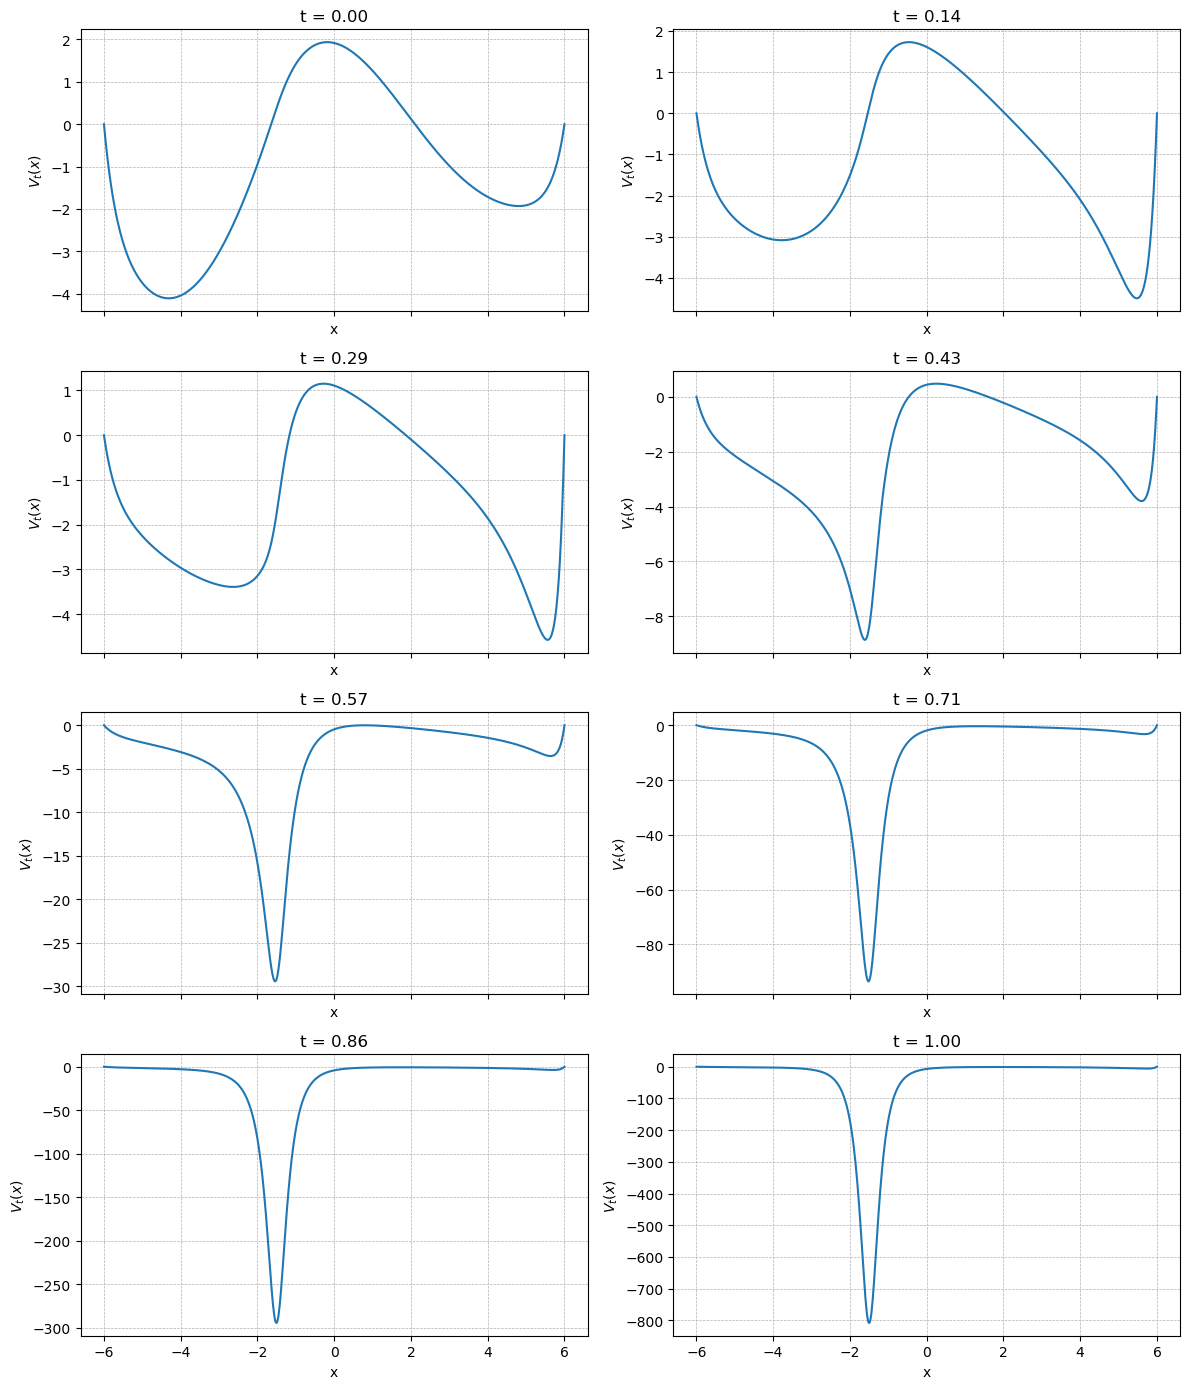

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz, cumulative_trapezoid

# Spatial grid
x = np.linspace(-6, 6, 800)

# Define energies f0 and f1
f0 = x**2 / 4.0
rho_mix = (1/2) * np.exp(-(x - 1)**2) + (1/2) * np.exp(-(x + 4)**2)
f1 = -np.log(rho_mix)

# Time points
t_values = np.array([0.00, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.00])
nt = len(t_values)

# Compute densities rho_t(x)
rho_ts = []
for t in t_values:
    f_t = (1 - t) * f0 + t * f1
    Z_t = trapz(np.exp(-f_t), x)
    rho_ts.append(np.exp(-f_t) / Z_t)
rho_ts = np.stack(rho_ts, axis=0)  # shape (nt, nx)

# Approximate ∂ρ/∂t via finite differences
drho_dt = np.zeros_like(rho_ts)
for i in range(nt):
    if i == 0:
        drho_dt[i] = (rho_ts[i+1] - rho_ts[i]) / (t_values[i+1] - t_values[i])
    elif i == nt-1:
        drho_dt[i] = (rho_ts[i] - rho_ts[i-1]) / (t_values[i] - t_values[i-1])
    else:
        drho_dt[i] = (rho_ts[i+1] - rho_ts[i-1]) / (t_values[i+1] - t_values[i-1])

# Plot V_t(x) in subplots with exact values and flexible axes
fig, axs = plt.subplots(4, 2, figsize=(12, 14), sharex=True, sharey=False)
axs = axs.flatten()

for ax, rho, drho, t in zip(axs, rho_ts, drho_dt, t_values):
    # Compute cumulative flux integral of ∂ρ/∂t
    flux = cumulative_trapezoid(drho, x, initial=0.0)
    V = -flux / rho
    
    # Plot the exact velocity field
    ax.plot(x, V)
    
    # Axis labels and title
    ax.set_title(f"t = {t:.2f}", fontsize=12)
    ax.set_xlabel("x", fontsize=10)
    ax.set_ylabel(r"$V_t(x)$", fontsize=10)
    
    # Auto-scale both axes to data
    ax.relim()
    ax.autoscale_view()
    
    ax.grid(True, which='both', ls='--', lw=0.5)

plt.tight_layout()
plt.show()


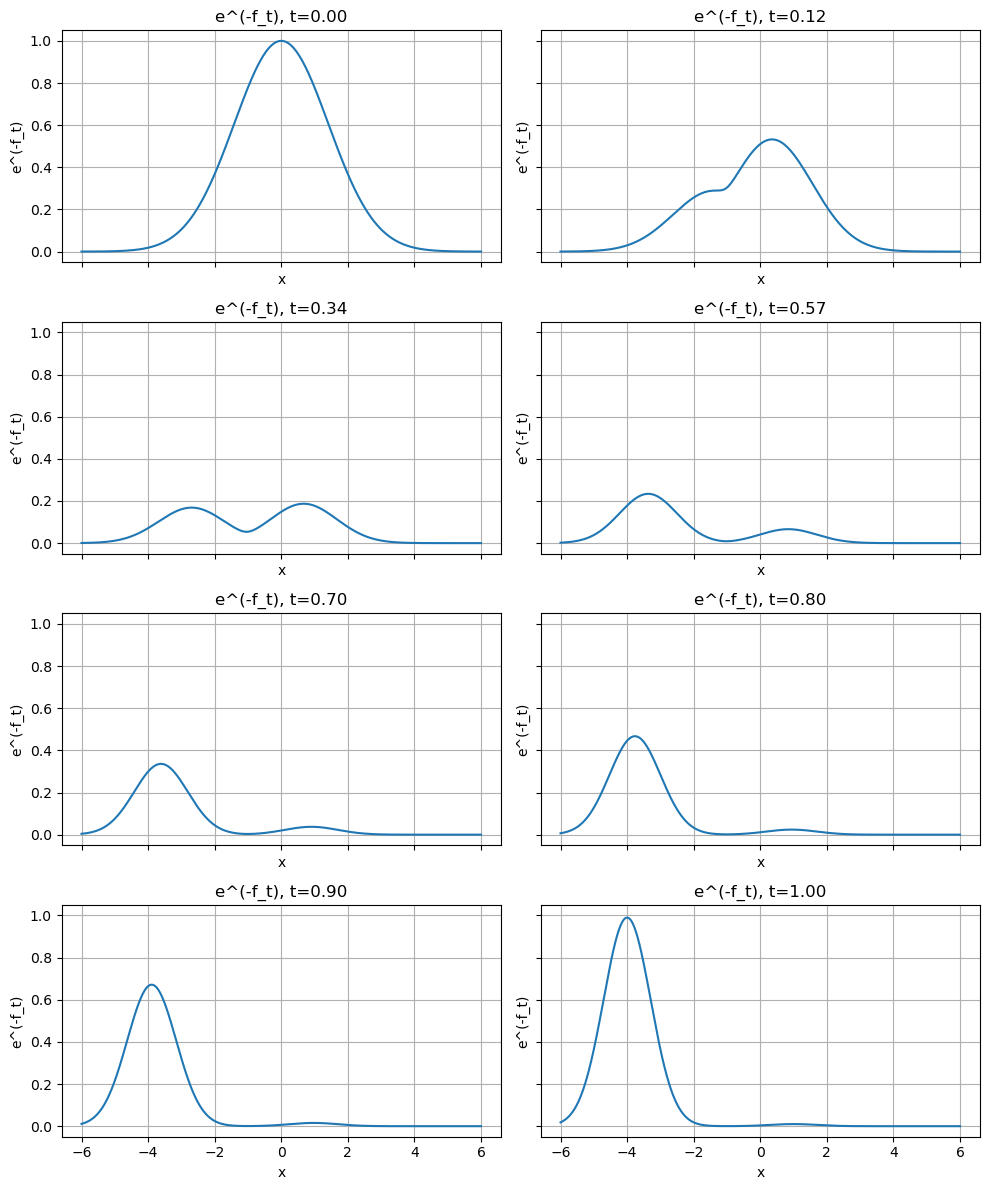

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define x grid
x = np.linspace(-6, 6, 800)

# Define f0 and f1
f0 = x**2 / 4.0
rho_mix = (0.01) * np.exp(-(x - 1)**2) + (0.99) * np.exp(-(x + 4)**2)
f1 = -np.log(rho_mix)

# t values
t_values = np.array([0.00, 0.12, 0.34, 0.57,0.7,0.8, 0.9, 1.00])

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(10, 12), sharex=True, sharey=True)
axs = axs.flatten()

for ax, t in zip(axs, t_values):
    f_t = (1 - t) * f0 + t * f1
    ax.plot(x, np.exp(-f_t))
    ax.set_title(f"e^(-f_t), t={t:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("e^(-f_t)")
    ax.grid(True)

plt.tight_layout()
plt.show()


/var/folders/4t/11m88h095j316m45r0hhy48r0000gn/T/ipykernel_28422/247358937.py:21: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  Z_t = trapz(np.exp(-f_t), x)


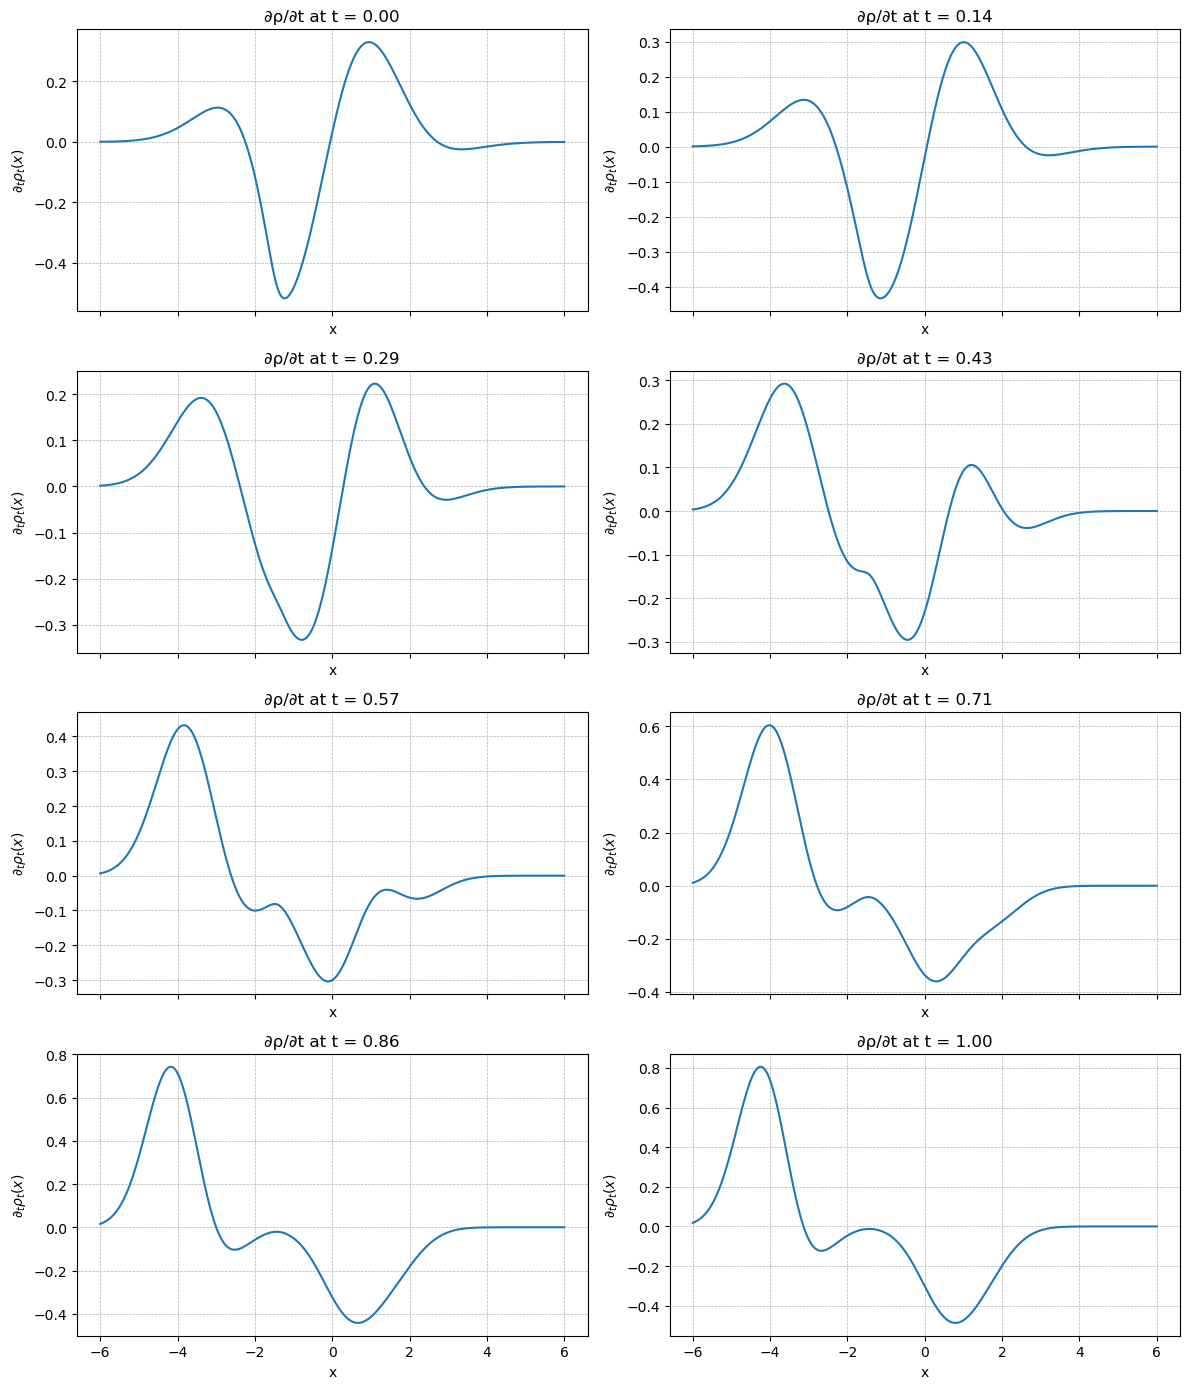

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Spatial grid
x = np.linspace(-6, 6, 800)

# Define energies f0 and f1
f0 = x**2 / 4.0
rho_mix = (1/3) * np.exp(-(x - 1)**2) + (2/3) * np.exp(-(x + 4)**2)
f1 = -np.log(rho_mix)

# Time points
t_values = np.array([0.00, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.00])
nt = len(t_values)

# Compute normalized densities rho_t(x)
rho_ts = []
for t in t_values:
    f_t = (1 - t) * f0 + t * f1
    Z_t = trapz(np.exp(-f_t), x)
    rho_ts.append(np.exp(-f_t) / Z_t)
rho_ts = np.stack(rho_ts, axis=0)  # shape (nt, nx)

# Compute ∂ρ/∂t via finite differences in t
drho_dt = np.zeros_like(rho_ts)
for i in range(nt):
    if i == 0:
        drho_dt[i] = (rho_ts[i+1] - rho_ts[i]) / (t_values[i+1] - t_values[i])
    elif i == nt-1:
        drho_dt[i] = (rho_ts[i] - rho_ts[i-1]) / (t_values[i] - t_values[i-1])
    else:
        drho_dt[i] = (rho_ts[i+1] - rho_ts[i-1]) / (t_values[i+1] - t_values[i-1])

# Plot ∂ρ_t/∂t in subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 14), sharex=True, sharey=False)
axs = axs.flatten()

for ax, drho, t in zip(axs, drho_dt, t_values):
    ax.plot(x, drho)
    ax.set_title(f"∂ρ/∂t at t = {t:.2f}", fontsize=12)
    ax.set_xlabel("x", fontsize=10)
    ax.set_ylabel(r"$\partial_t \rho_t(x)$", fontsize=10)
    ax.relim()
    ax.autoscale_view()
    ax.grid(True, ls='--', lw=0.5)

plt.tight_layout()
plt.show()


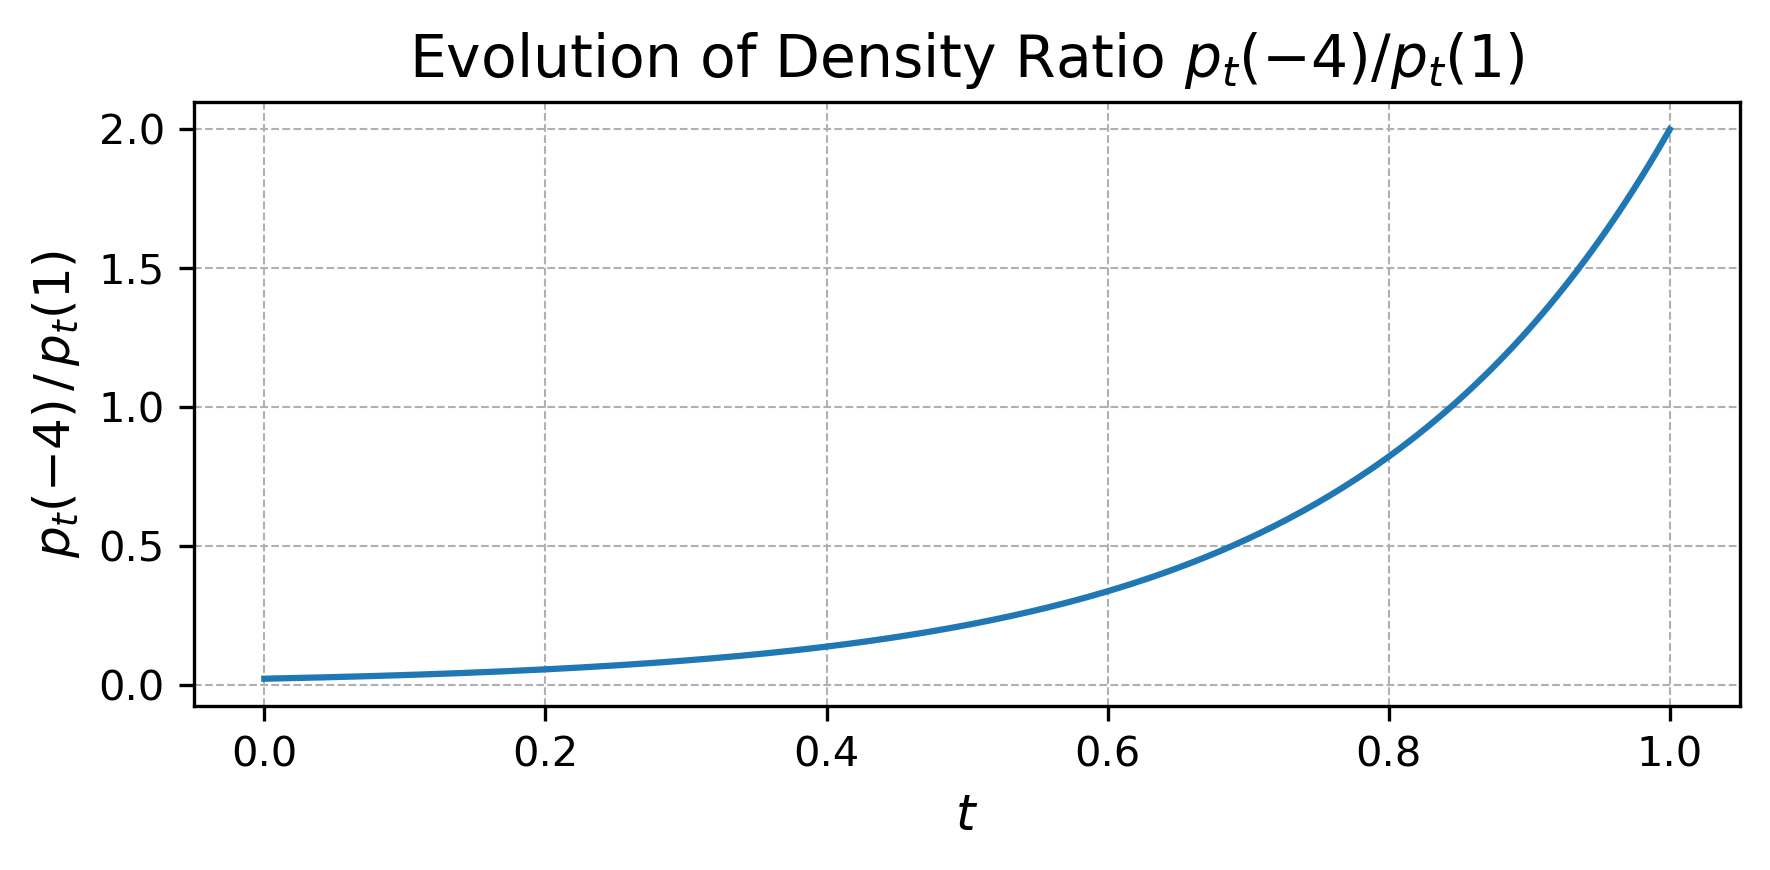

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Time grid for interpolation
t = np.linspace(0, 1, 200)

# Base energy f0 at x = -4 and x = 1
f0_neg4 = (-4)**2 / 4.0
f0_pos1 = (1)**2 / 4.0

# Mixture density components
rho_mix_neg4 = 1/3 * np.exp(-(-4 - 1)**2) + 2/3 * np.exp(-(-4 + 4)**2)
rho_mix_pos1 = 1/3 * np.exp(-(1 - 1)**2) + 2/3 * np.exp(-(1 + 4)**2)

# Target energy f1 at x = -4 and x = 1
f1_neg4 = -np.log(rho_mix_neg4)
f1_pos1 = -np.log(rho_mix_pos1)

# Interpolated energies f_t(x)
f_t_neg4 = (1 - t) * f0_neg4 + t * f1_neg4
f_t_pos1 = (1 - t) * f0_pos1 + t * f1_pos1

# Density ratio p_t(-4)/p_t(1) = exp(-f_t(-4)) / exp(-f_t(1))
ratio_p = np.exp(-f_t_neg4) / np.exp(-f_t_pos1)

# Plotting
plt.figure(figsize=(6, 3),dpi = 300)
plt.plot(t, ratio_p)
plt.xlabel(r"$t$", fontsize=12)
plt.ylabel(r"$p_t(-4)\,/\,p_t(1)$", fontsize=12)
plt.title("Evolution of Density Ratio $p_t(-4)/p_t(1)$", fontsize=14)
plt.grid(True, ls='--', lw=0.5)
plt.tight_layout()
plt.show()
